In [2]:
import numpy as np
import pandas as pd
import itertools
import random
import string
import networkx as nx
import matplotlib.pyplot as plt



# Kauffman Simulation

In [ ]:
iterable = ["A", "B"]

In [ ]:
poss_mols = []
food = []
for i in range(1,n+1):
    poss= list(itertools.combinations_with_replacement(iterable, i))
    if i <= t:
        f= list(itertools.combinations_with_replacement(iterable, i))
        food.append(f)
    
    poss_mols.append(poss)

food =  list(itertools.chain(*food))
poss_mols = list(itertools.chain(*poss_mols))

In [ ]:
food

In [ ]:
poss_mols

In [3]:
n = 3
t = 2
max_len = 5
reps = 100


# RAF

### Pre-processing

In [112]:
def create_rxn_network (n, num_reactions, food_size, c_p = 0.25, reactants =2, k = 2):
    # Set of Molecules
    X = [''.join(i) for i in itertools.product(string.ascii_uppercase, repeat=k)][0:n]

    # Food (subset of molecules)
    #food_size = int(f_p*n)
    F = random.sample(X, food_size)

    # Reaction (pair of molecules)
    #num_reactions = int(r_p * n)
    R = {}
    for i in range(num_reactions):
        x= random.sample(X, 1)[0]
        react = random.sample(X, reactants)
        while x in react:
            x= random.sample(X, 1)[0]
        R[i] = [react, x]


    #no self-catalyzing
    # Duplicates in dictionary

    num_catal = int(c_p * n)

    C = {}
    for i in range(num_reactions):
        for j in X:
            if  np.random.random(1)[0]< c_p:
                if j in C.keys():
                    C[j].append(i)
                else:
                    C[j]= [i]
    
    return (X, F, R, C)

In [148]:
alphabet = string.ascii_uppercase[0:2]

[''.join(i) for i in itertools.product(alphabet, repeat=2)]

['AA', 'AB', 'BA', 'BB']

In [ ]:
def create_kauffman_network (n, t,k = 2, reactants =2, ):
    # Set of Molecules
    X = []
    F = []
    alphabet = string.ascii_uppercase[0:k]
    for i in range(n):
        X.append([''.join(i) for i in itertools.product(alphabet, repeat=i)])
        if i <= t:
            F.append([''.join(i) for i in itertools.product(alphabet, repeat=i)])

    # Food (subset of molecules)
    #food_size = int(f_p*n)
    F = random.sample(X, food_size)

    # Reaction (pair of molecules)
    #num_reactions = int(r_p * n)
    R = {}
    for i in range(num_reactions):
        x= random.sample(X, 1)[0]
        react = random.sample(X, reactants)
        while x in react:
            x= random.sample(X, 1)[0]
        R[i] = [react, x]


    #no self-catalyzing
    # Duplicates in dictionary

    num_catal = int(c_p * n)

    C = {}
    for i in range(num_reactions):
        for j in X:
            if  np.random.random(1)[0]< c_p:
                if j in C.keys():
                    C[j].append(i)
                else:
                    C[j]= [i]
    
    return (X, F, R, C)

In [37]:
def graph (X, F, R, C):
    DG = nx.DiGraph()

  

    for node in X:
   
        if node in F:
            DG.add_node(node, ncolor = "orange")
           
        else:
            DG.add_node(node, ncolor = 'lawngreen')
        

    for node in R: 
        text = "R{}".format(node)
        DG.add_node(text, ncolor = 'salmon')
    

        for i in range(len(R[node][0])):
            DG.add_edge(R[node][0][i], text, weight = -1)
        
        DG.add_edge(text,R[node][1], weight = -1)
  

    for j in C:
        for k in C[j]:
            if j in X and k in list(R.keys()):
                text = "R{}".format(k)
                DG.add_edge(j, text, weight = 1)


    for edge in DG.edges(data=True):
        weight = edge[2]["weight"]

        if weight > 0:
            color = "fuchsia"
        elif weight < 0:
            color = "steelblue"
        edge[2]["color"] = color
        
    
    

   
    edge_colors = [DG[u][v]['color'] for u,v in DG.edges()]
    
    node_colors = list(nx.get_node_attributes(DG, "ncolor").values())
 
    
    # print("----")
    # print(DG.nodes())
    # print(node_colors)


    nx.draw(DG, node_color= node_colors, edge_color = edge_colors, with_labels=True, font_weight='bold', node_size = 750, pos=nx.circular_layout(DG))
    
    plt.show()

### RAF Algorithm

In [38]:
# Find all possible molecules able to be produced by the food set and available reactions

def closure(F, R):
    no_change = 0
    X = F

    while no_change !=1:
        no_change = 1

        for i in list(R.values()):
            sufficient = 1
            for j in i[0]:
                if j not in X:
                    sufficient = 0
            if sufficient == 1:
                if i[1] not in X:
                    X.append(i[1])
                    no_change = 0
    return(X)
            


In [57]:
# Applies R1: Remove all reactions that are not catalyzed by a molecule involved in our system

def reduceR(R, C):
    no_change = 0
    catalyzed = [element for sublist in list(C.values()) for element in sublist]
    uncat_R = list(set(R.keys()) - set(catalyzed))

    for i in uncat_R:
        del R[i]

    catalysts = list(C.keys())
    while no_change != 1:
        R_supp = Rsupp(R)
 
        no_change =1

        for i in catalysts:
            if i not in R_supp:
                #remove reaction
                for k in C[i]:
                    if k in R.keys():
                        del R[k]
                        no_change = 0
      
        

                    
         
    return(R)
            

In [41]:
def Rsupp (R):
    supp = []
    for i in list(R.values()):
        cands = [i[0][0],  i[0][1],i[1]]
        for j in cands:
            if j not in supp:
                supp.append(j)
    return(supp)


In [42]:
def reduceToF(F, R):
    W = closure(F,R)
    reactants = list(R.values())
    r_num= list(R.keys())
    
    for i in range(len(list(R.values()))):
        remove = 0
        
        for j in reactants[i][0]:
            if j not in W:
                remove = 1
        if remove == 1:
            del R[r_num[i]]


    
    return R

In [141]:
def RAF_pictoral(X,F,R,C):
    X_old = X.copy()
    R_old = R.copy()
    F_original = F.copy()
    print("Initial")
    graph(X, F, R, C)

    i = 0 
    change = 0
    while change != 1:
        R = reduceR(R, C)
        X = closure(F,R)
        R = reduceToF(F,R)
        i= i+1

        if R != False and X != False:

            print("Round {}".format(i))
            # print(X)
            # print(R)
            # print("---")
            # print(X_old)
            # print(R_old)
            # print("")
        


            graph(X, F_original, R, C)
            # print(X_old)
            # print(X)
            # print("----")
            # print(R_old)
            # print(R)
            if X_old == X and R_old == R:
                change = 1
            else:
                R_old = R
                X_old = X
        else:
            break

    

In [132]:
def RAF(X,F,R,C):
    X_old = X.copy()
    R_old = R.copy()
    F_original = F.copy()
    print("Initial")
    graph(X, F, R, C)

    i = 0 
    change = 0
    while change != 1:
        R = reduceR(R, C)
        X = closure(F,R)
        R = reduceToF(F,R)
        i= i+1

        if R != False and X != False:


            if X_old == X and R_old == R:
                change = 1
            else:
                R_old = R
                X_old = X
        else:
            break
    print("Output")
    graph(X, F_original, R, C)
    

# Examples

## Random Network

In [142]:
X, F, R, C = create_rxn_network (n=10, num_reactions = 40, food_size = 5 , c_p = 0.25, reactants =2)

In [138]:
R

{0: [['AJ', 'AF'], 'AD'],
 1: [['AI', 'AH'], 'AC'],
 2: [['AE', 'AJ'], 'AA'],
 3: [['AJ', 'AB'], 'AC'],
 4: [['AA', 'AG'], 'AF'],
 5: [['AH', 'AG'], 'AJ'],
 6: [['AD', 'AG'], 'AB'],
 7: [['AE', 'AB'], 'AJ'],
 8: [['AH', 'AI'], 'AF'],
 9: [['AD', 'AE'], 'AF'],
 10: [['AE', 'AB'], 'AH'],
 11: [['AA', 'AH'], 'AE'],
 12: [['AC', 'AI'], 'AH'],
 13: [['AF', 'AD'], 'AJ'],
 14: [['AD', 'AH'], 'AG'],
 15: [['AJ', 'AC'], 'AF'],
 16: [['AH', 'AF'], 'AI'],
 17: [['AE', 'AF'], 'AA'],
 18: [['AH', 'AC'], 'AD'],
 19: [['AH', 'AA'], 'AB'],
 20: [['AA', 'AH'], 'AB'],
 21: [['AF', 'AC'], 'AJ'],
 22: [['AD', 'AJ'], 'AG'],
 23: [['AD', 'AG'], 'AE'],
 24: [['AG', 'AA'], 'AB'],
 25: [['AH', 'AC'], 'AA'],
 26: [['AE', 'AG'], 'AJ'],
 27: [['AB', 'AC'], 'AE'],
 28: [['AH', 'AC'], 'AF'],
 29: [['AF', 'AD'], 'AI'],
 30: [['AJ', 'AC'], 'AA'],
 31: [['AA', 'AJ'], 'AC'],
 32: [['AC', 'AJ'], 'AI'],
 33: [['AB', 'AI'], 'AA'],
 34: [['AI', 'AA'], 'AF'],
 35: [['AE', 'AA'], 'AI'],
 36: [['AJ', 'AG'], 'AB'],
 37: [['AA'

In [139]:
C

{'AD': [0, 15, 17, 27, 32, 33, 38],
 'AG': [0, 2, 4, 11, 13, 15, 16, 23, 30, 32, 35, 39],
 'AA': [1, 4, 8, 9, 15, 17, 33, 36, 39],
 'AH': [1, 3, 6, 7, 18, 20, 23, 24, 32, 33, 35],
 'AB': [2, 20, 23, 26, 30, 31, 36, 37, 39],
 'AE': [2, 3, 4, 11, 12, 19, 22, 23, 28, 32],
 'AJ': [4, 11, 15, 16, 25, 27, 29, 31, 34],
 'AC': [6, 9, 12, 14, 18, 20, 21, 25, 29, 31, 32, 34, 35],
 'AF': [6, 18, 22, 23, 27, 33, 38],
 'AI': [6, 16, 21, 22, 24, 27, 31]}

Initial


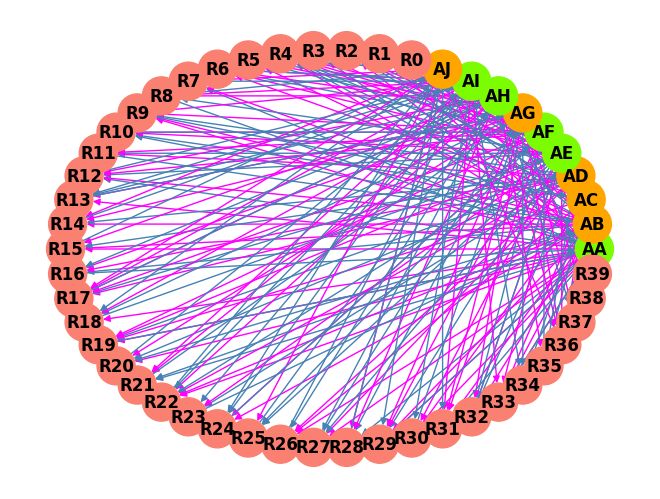

Round 1


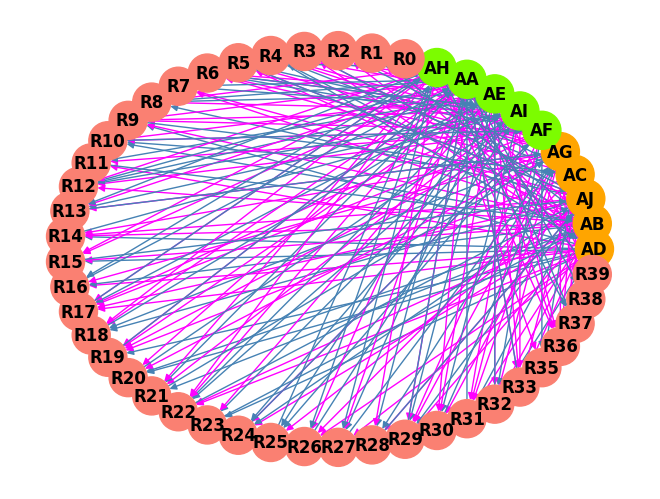

Round 2


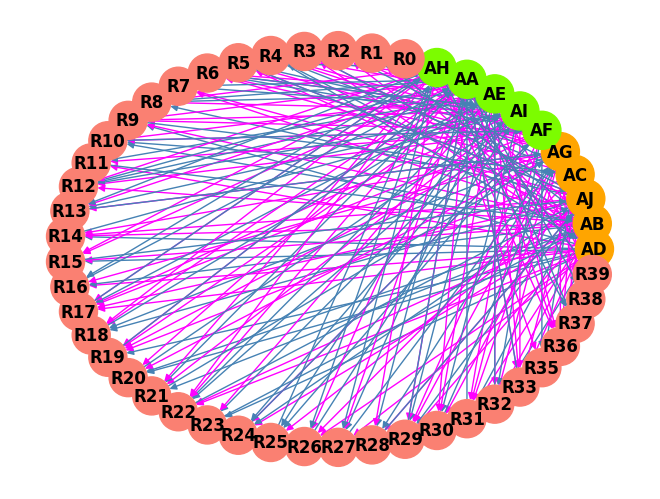

In [143]:
RAF_pictoral(X, F, R, C)

## Hordjik04 Example

In [135]:
X = [''.join(i) for i in itertools.product(string.ascii_uppercase, repeat=2)][0:7]
R = {1: [["AA", "AB"], "AC"],
    2: [["AB", "AC"], "AD"],
    3: [["AC", "AD"], "AE"],
    4: [["AC", "AD"], "AF"],
    5: [["AA", "AE"], "AG"],
 }
F = ["AA", "AB"]
C = {"AD": [1], "AA":[2], "AF":[5] }

Initial


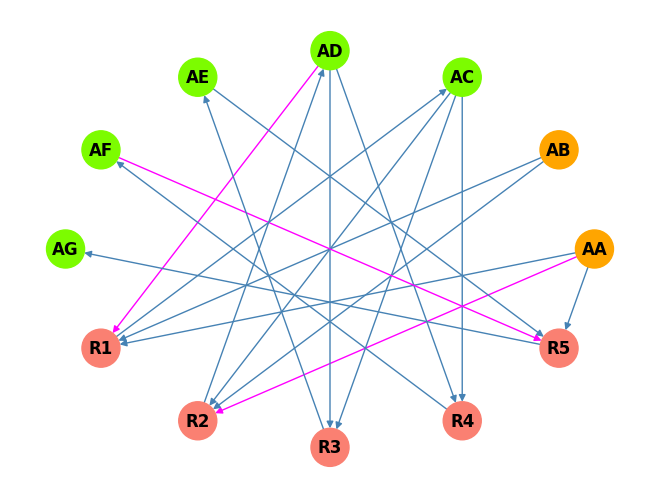

Round 1


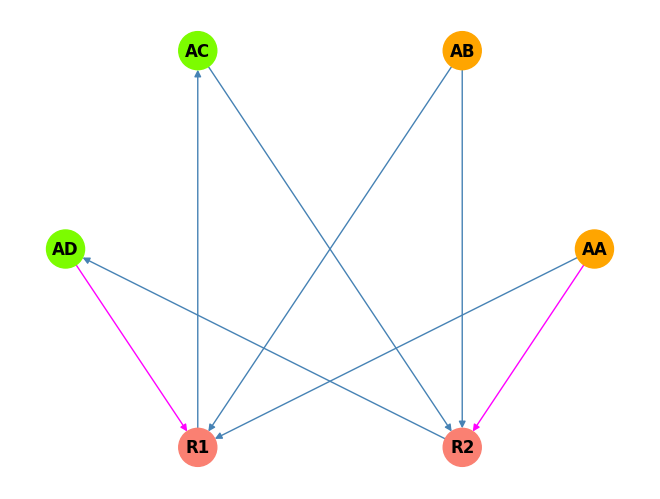

['AA', 'AB', 'AC', 'AD', 'AE', 'AF', 'AG']
['AA', 'AB', 'AC', 'AD']
----
{1: [['AA', 'AB'], 'AC'], 2: [['AB', 'AC'], 'AD'], 3: [['AC', 'AD'], 'AE'], 4: [['AC', 'AD'], 'AF'], 5: [['AA', 'AE'], 'AG']}
{1: [['AA', 'AB'], 'AC'], 2: [['AB', 'AC'], 'AD']}
Round 2


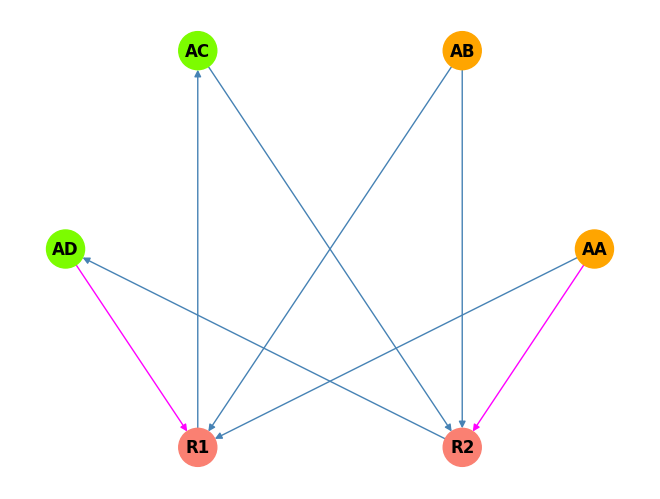

['AA', 'AB', 'AC', 'AD']
['AA', 'AB', 'AC', 'AD']
----
{1: [['AA', 'AB'], 'AC'], 2: [['AB', 'AC'], 'AD']}
{1: [['AA', 'AB'], 'AC'], 2: [['AB', 'AC'], 'AD']}


In [136]:
RAF_pictoral(X, F, R,C)

Initial


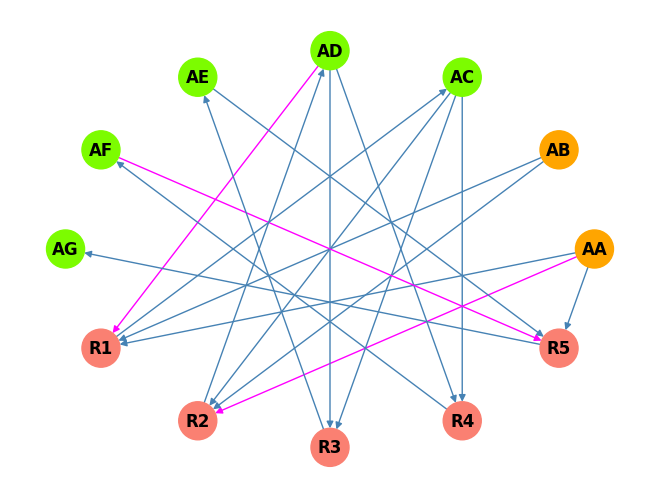

Output


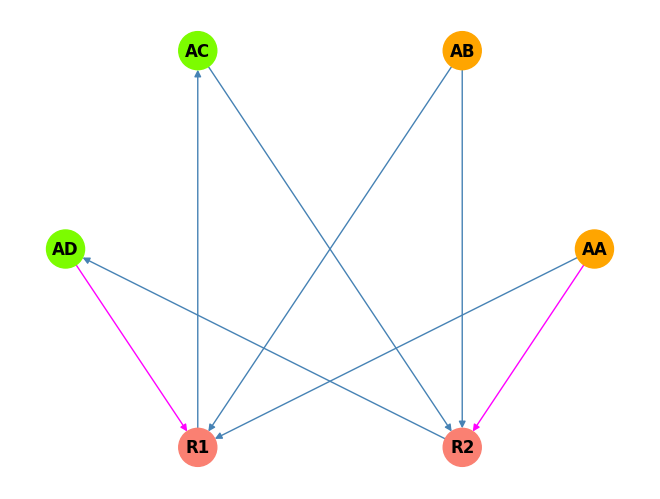

In [134]:
RAF(X,F,R,C)